In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in Data

In [2]:
j_faults = pd.read_csv('../data/J1939Faults.csv').reset_index(drop = True)
onboard_data = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv').reset_index(drop = True)
fault_codes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx').reset_index(drop = True)

C:\Users\hjrko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
ob_data = onboard_data.pivot(index='FaultId', columns='Name',values = 'Value').rename_axis(None)
pd.set_option('display.max_columns', None)
ob_data.reset_index(inplace=True)
ob_data = ob_data.rename(columns = {'index':'FaultId'})

In [4]:
ob_faults = pd.merge(j_faults, ob_data, how='left', left_on='RecordID', right_on='FaultId')

# Transform Data

In [5]:
problem_cols = ['AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure']

for x in problem_cols:
    try:
        ob_faults[x] = ob_faults[x].str.replace(',','').astype(float)
    except ValueError:
        ob_faults[x] = ob_faults[x]

In [6]:
ob_faults['EventTimeStamp'] = ob_faults['EventTimeStamp'].astype('datetime64[ns]')
ob_faults['LocationTimeStamp'] = ob_faults['LocationTimeStamp'].astype('datetime64[ns]')

In [7]:
ob_faults = ob_faults.sort_values(['EquipmentID','EventTimeStamp']).reset_index().drop(columns=['index'])

# Filter Out Certain Data

In [8]:
ob_faults = ob_faults[~((ob_faults['Longitude'].astype('str').str.contains(r'-86.44\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'35.58\d+')))]
ob_faults = ob_faults[~((ob_faults['Longitude'].astype('str').str.contains(r'-86.4\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.0\d+')))]
ob_faults = ob_faults[~((ob_faults['Longitude'].astype('str').str.contains(r'-83.17\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.19\d+')))]

In [9]:
ob_faults['EquipmentID'] = ob_faults['EquipmentID'].astype(str)
ob_faults = ob_faults[ob_faults['EquipmentID'].str.len() < 6]

In [10]:
ob_faults = ob_faults[~(ob_faults['eventDescription'].astype('str').str.contains(r'Data May Be Invalid\D+'))]
ob_faults = ob_faults[~((ob_faults['EventTimeStamp'].dt.year < 2015) | (ob_faults['EventTimeStamp'].dt.year > 2022))]
ob_faults = ob_faults.sort_values(['EquipmentID', 'EventTimeStamp'], ascending=False)

In [11]:
cond = [(ob_faults['spn'] == 1569) | (ob_faults['spn'] == 5246), ob_faults['spn']!=1569]
choices = [True, False]
ob_faults['derate'] = np.select(cond, choices)

In [12]:
cond2 = [(ob_faults['spn'] == 5246), (ob_faults['spn'] != 5246)]
choices2 = [True, False]
ob_faults['full_derate'] = np.select(cond2, choices2)

In [13]:
ob_faults['full_derate'].value_counts()

0    1046749
1        927
Name: full_derate, dtype: int64

# Time Series Analysis

In [14]:
time_series = pd.read_csv('../data/no_consec.csv')
time_series

C:\Users\hjrko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,index,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate,full_derate,derate_cumulative,derate_cumu_diff,next_timestamp,time_diff_next,time_diff_next_h,updated_time,new_time_diff
0,0,23868,42689,2241022,2015-05-04 15:38:35,NaN,NaN,unknown,unknown,unknown,unknown,49,50353,0,True,2,NaN,1327,105383198,35.988750,-83.579583,2015-05-04 15:39:11,100.0,14.2825,False,62.13712,517711.80,183.2,90.0,33.64,216.6125,1359.125,10323.10,NaN,78862.886425,16.854230,NaN,True,113.0,2.0,False,NaN,64.680850,3276.75,NaN,26.39,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,23869,42692,2241075,2015-05-04 15:42:02,NaN,NaN,unknown,unknown,unknown,unknown,49,50353,0,False,2,NaN,1327,105383198,35.983796,-83.631944,2015-05-04 15:41:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,2015-05-04 15:38:35,0 days 00:03:27,0.057500,NaN,NaN
2,2,23870,45667,2296851,2015-05-07 06:52:14,Condition Exists Cruise Control Enable Switch,NaN,unknown,unknown,unknown,unknown,49,596,31,True,126,NaN,1327,105383198,40.197500,-74.661435,2015-05-07 06:52:50,0.0,14.7900,False,64.62260,518554.70,185.0,14.0,25.52,165.8750,648.375,10338.70,NaN,78990.877785,0.766101,NaN,True,102.2,255.0,False,NaN,0.000000,3276.75,NaN,1.74,0,0,0,0.0,2015-05-04 15:42:02,2 days 15:10:12,63.170000,NaN,NaN
3,3,23871,45945,2302281,2015-05-07 10:25:59,Condition Exists Cruise Control Enable Switch,NaN,unknown,unknown,unknown,unknown,49,596,31,False,126,NaN,1327,105383198,40.198148,-74.660879,2015-05-07 10:25:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,2015-05-07 06:52:14,0 days 03:33:45,3.562500,NaN,NaN
4,4,23872,58809,2507532,2015-05-19 12:02:55,Abnormal Update Rate Aftertreatment 1 Intake NOx,NaN,04993120*00001782*082113134117*07700053*I0*BBZ*,79419774,6X1u10D1500000000,CMMNS,0,3216,9,True,1,NaN,1327,105383198,35.491250,-86.458842,2015-05-19 12:03:32,11.6,14.3550,False,64.62260,520309.60,185.0,0.0,31.90,203.8438,1083.125,10374.80,NaN,79274.466482,0.000000,NaN,True,109.4,17407.0,False,NaN,27.563640,3276.75,NaN,2.90,0,0,0,0.0,2015-05-07 10:25:59,12 days 01:36:56,289.615556,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051340,1051340,1187330,4495,1052146,2015-02-24 16:24:05,Low (Severity Medium) Catalyst Tank Level,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,1761,18,False,11,NaN,R1762,105442816,39.551851,-86.045925,2015-02-24 16:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,404,0.0,2015-02-24 15:31:56,0 days 00:52:09,0.869167,NaN,NaN
1051341,1051341,1187331,6439,1089561,2015-02-26 13:12:11,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,5848,9,True,1,NaN,R1762,105442816,39.952870,-81.936990,2015-02-26 13:12:48,0.0,14.2100,False,66.48672,80838.70,134.6,11.0,38.86,148.7188,595.750,1547.55,22.4,11527.675833,0.660432,32.0,True,84.2,17407.0,False,NaN,2.058292,3276.75,0.0,0.29,0,0,404,0.0,2015-02-24 16:24:05,1 days 20:48:06,44.801667,NaN,NaN
1051342,1051342,1187332,6447,1090499,2015-02-26 13:50:59,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,5848,9,False,1,NaN,R1762,105442

# Analysis of Onboard Diagnostics 

In [15]:
condensed_df = ob_faults.sort_values(['EquipmentID', 'EventTimeStamp', 'spn', 'fmi'])[[
    'EquipmentID', 
    'EventTimeStamp', 
    'eventDescription', 
    'spn', 
    'fmi', 
    'active', 
    'activeTransitionCount', 
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlActive',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IgnStatus',
    'IntakeManifoldTemperature',
    'LampStatus',
    'ParkingBrake',
    'ServiceDistance',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure']]

spn_prior_to_75_derate = condensed_df[((condensed_df['spn'].shift(-1) == 1569) & (condensed_df['fmi'].shift(-1) == 31))]
spn_prior_to_75_derate = spn_prior_to_75_derate[~((spn_prior_to_75_derate['spn'] == 1569) & (spn_prior_to_75_derate['fmi'] == 31))]
spn_prior_to_full_derate = condensed_df[((condensed_df['spn'].shift(-1) == 5246))]
spn_prior_to_full_derate = spn_prior_to_full_derate[~(spn_prior_to_full_derate['spn'] == 5246)]

mask = (((condensed_df['spn'].shift(-1) == 1569) & (condensed_df['fmi'].shift(-1) == 31)) | 
        (condensed_df['spn'].shift(-1) == 5246))

spn_not_related_to_derate = condensed_df[~mask]
spn_not_related_to_derate = spn_not_related_to_derate[~(spn_not_related_to_derate['spn'] == 5246)]
spn_not_related_to_derate = spn_not_related_to_derate[~((spn_not_related_to_derate['spn'] == 1569) & (spn_not_related_to_derate['fmi'] == 31))]

spn_prior_to_any_derate = condensed_df[mask]
spn_prior_to_any_derate = spn_prior_to_any_derate[~(spn_prior_to_any_derate['spn'] == 5246)]
spn_prior_to_any_derate = spn_prior_to_any_derate[~((spn_prior_to_any_derate['spn'] == 1569) & (spn_prior_to_any_derate['fmi'] == 31))]

spn_count = spn_prior_to_full_derate.groupby('spn').count().reset_index().sort_values('EquipmentID', ascending=False).head(20)

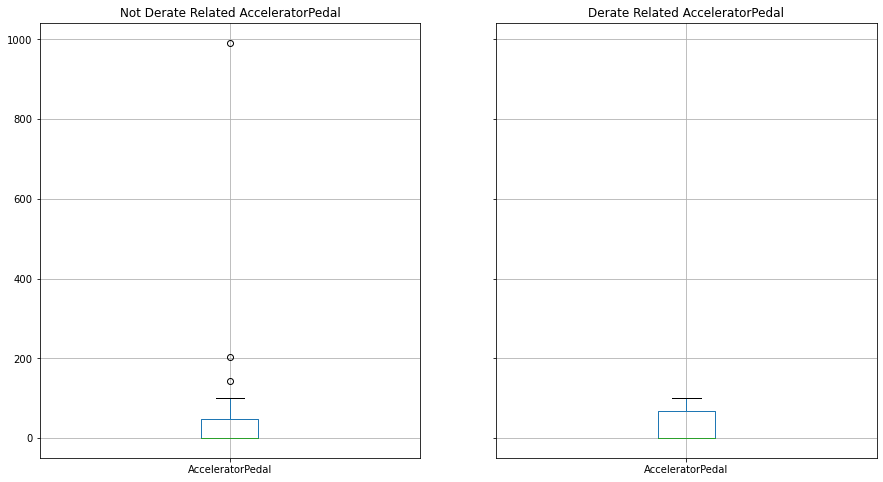

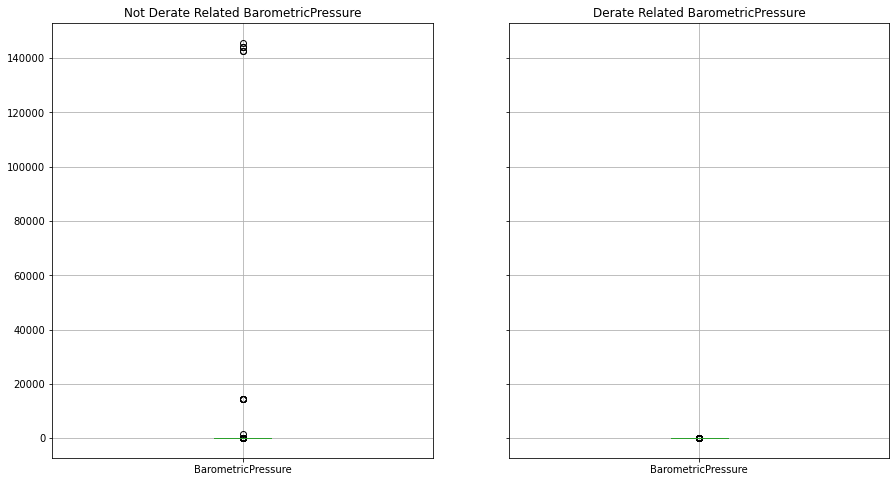

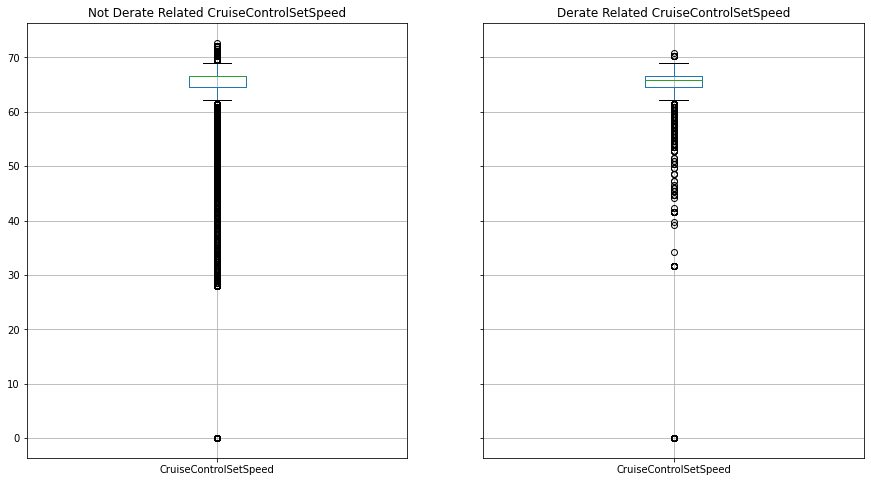

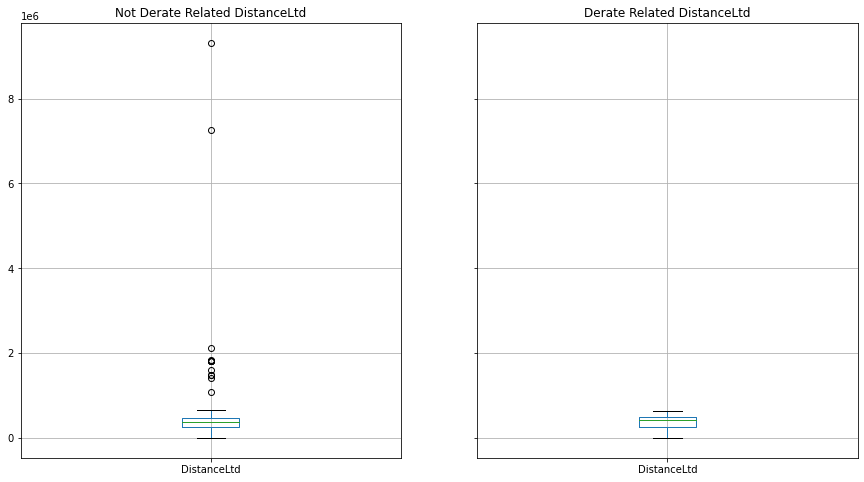

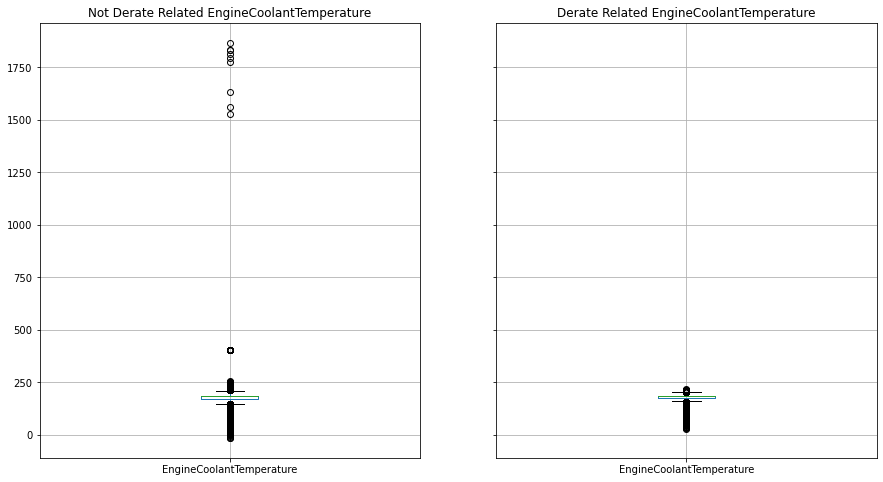

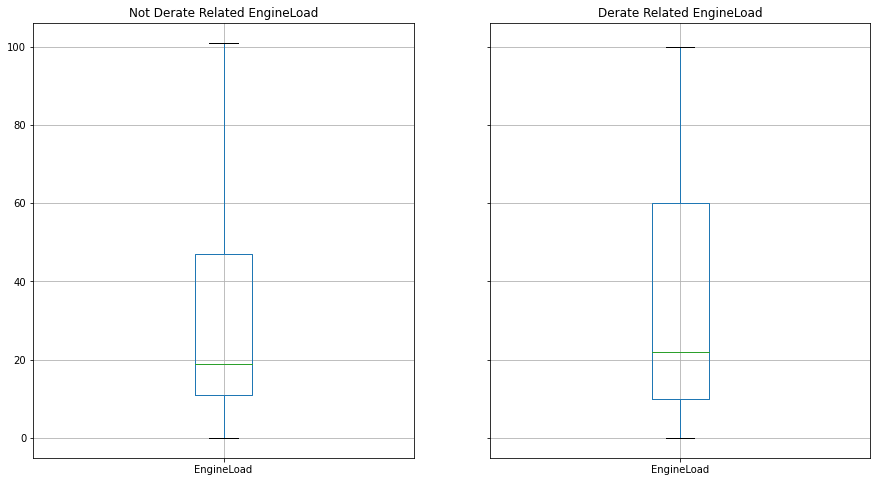

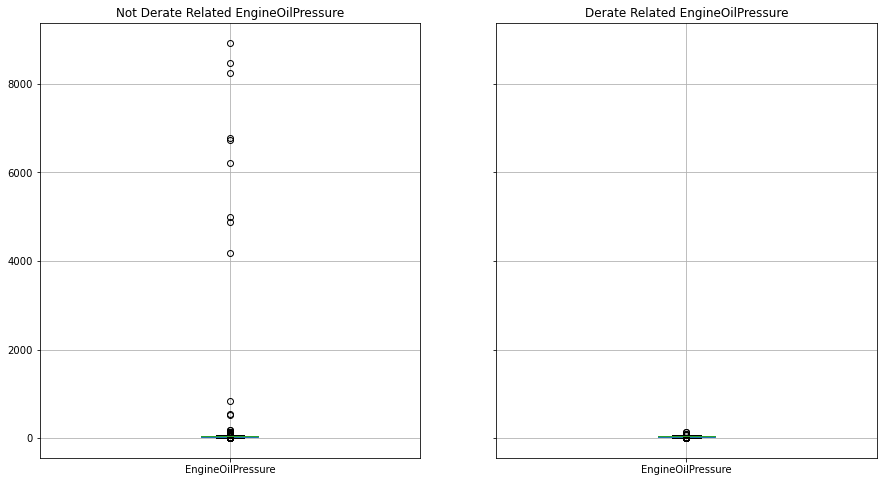

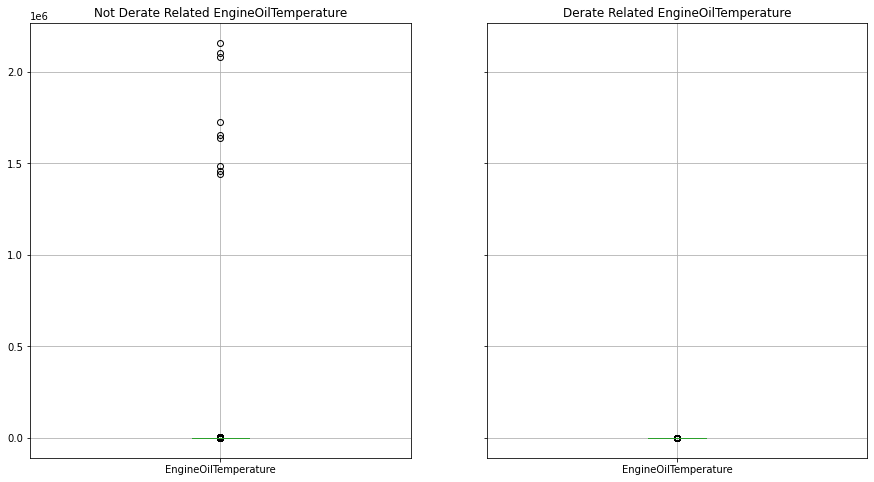

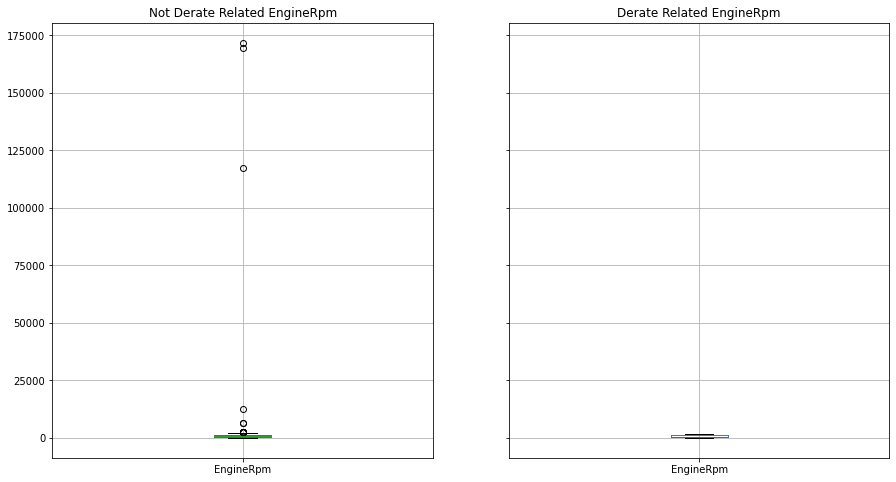

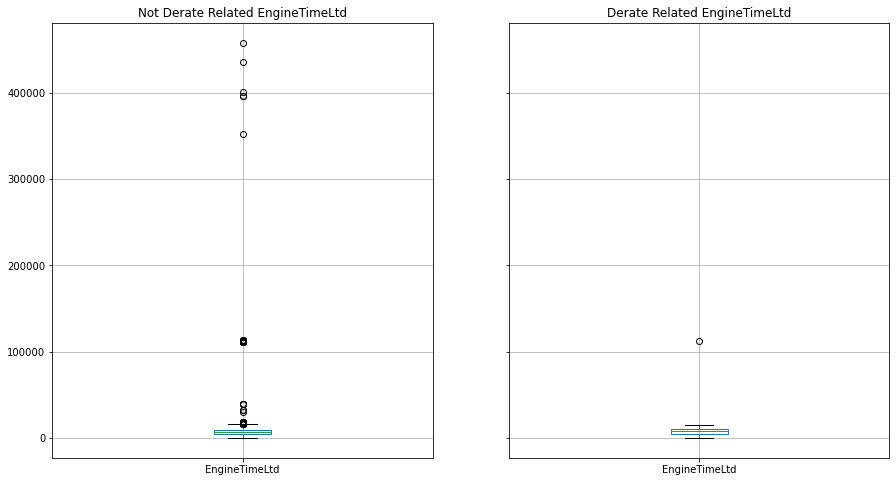

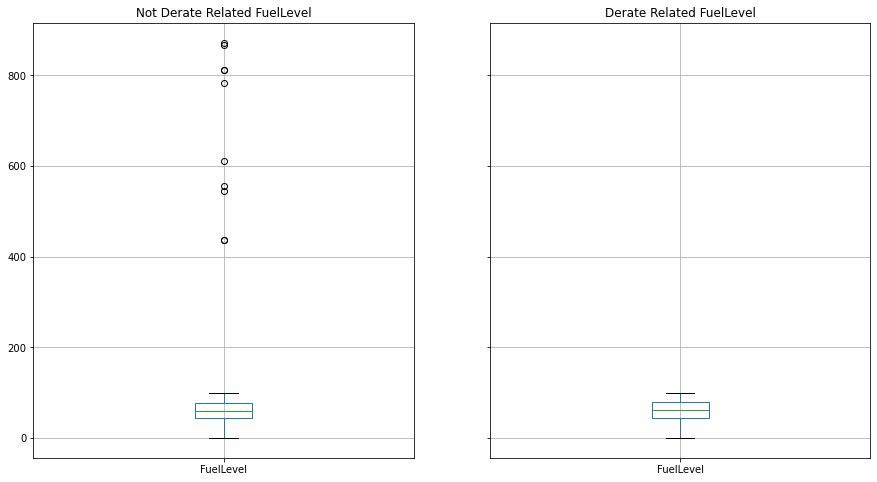

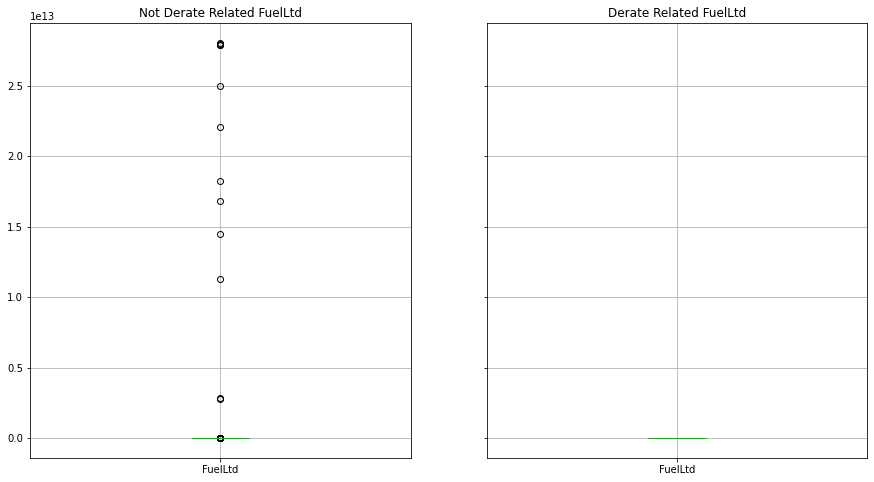

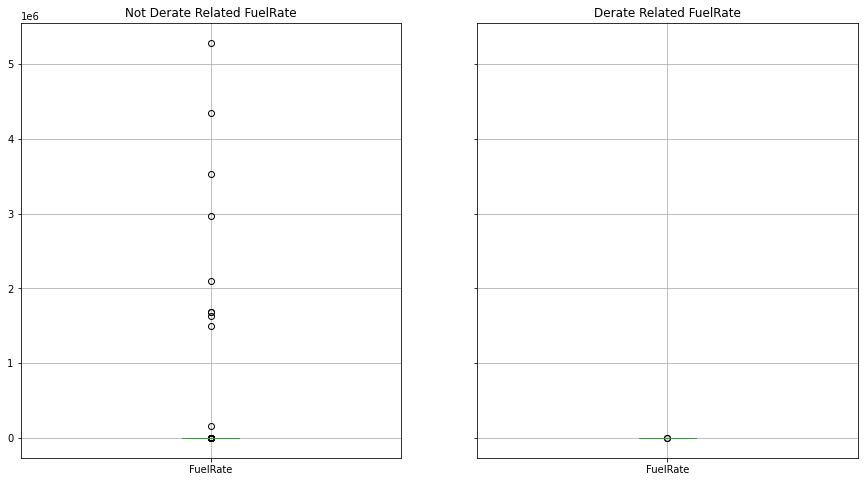

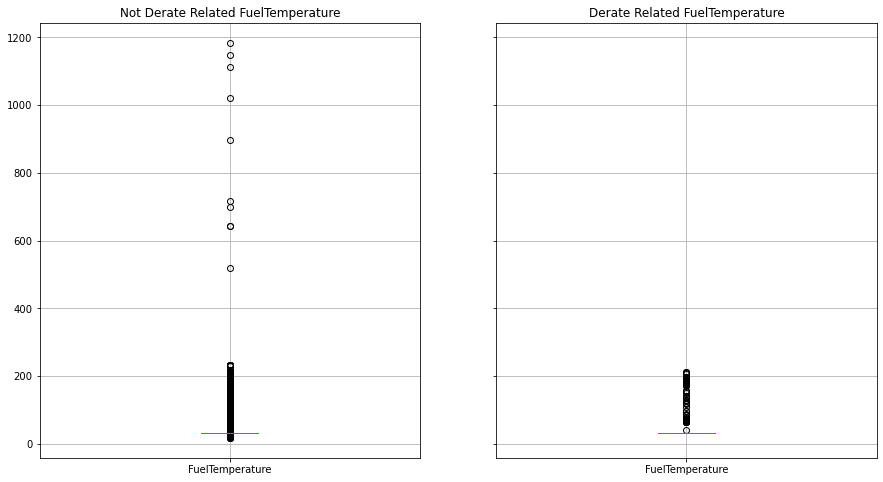

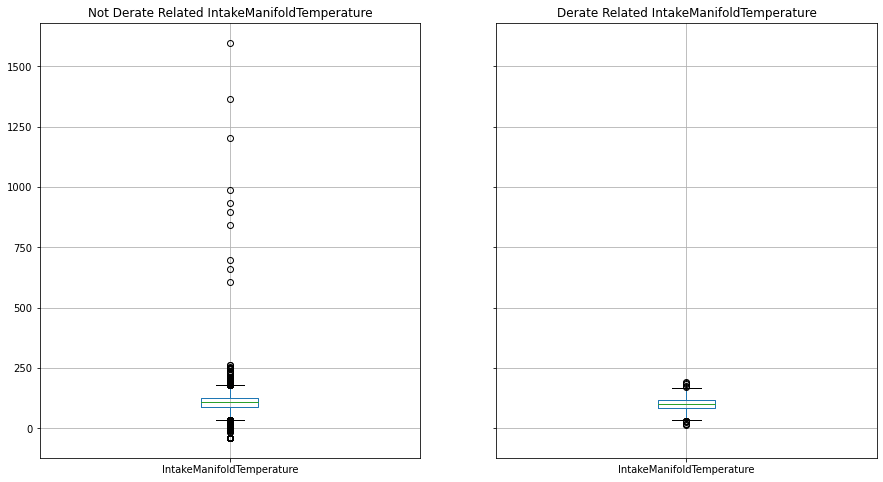

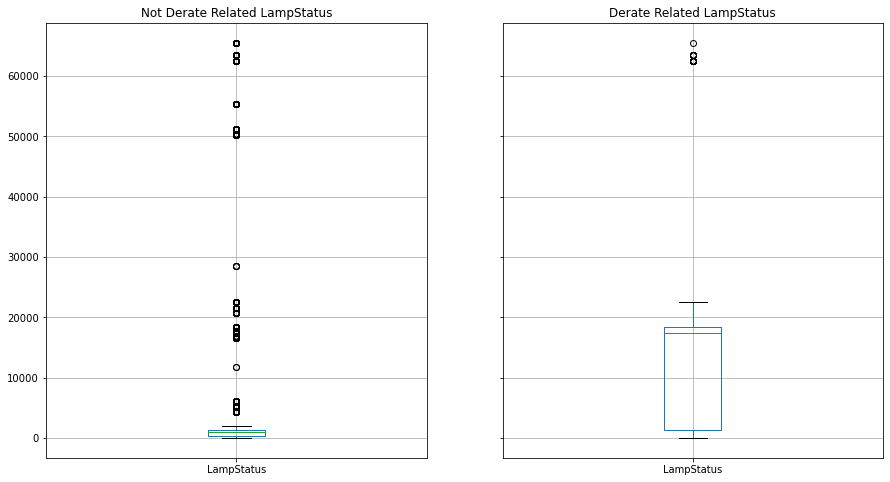

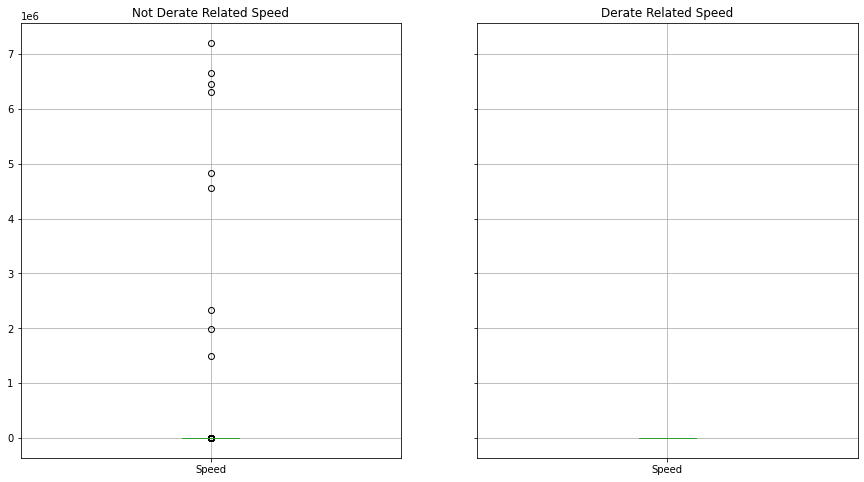

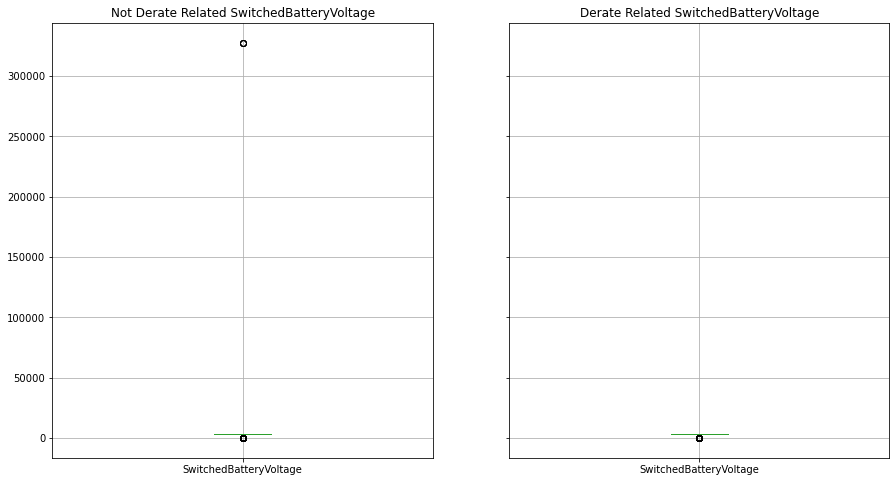

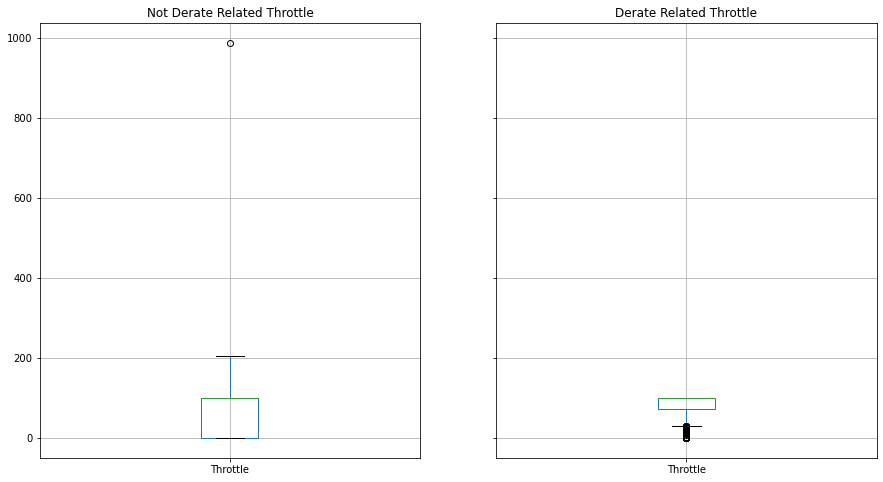

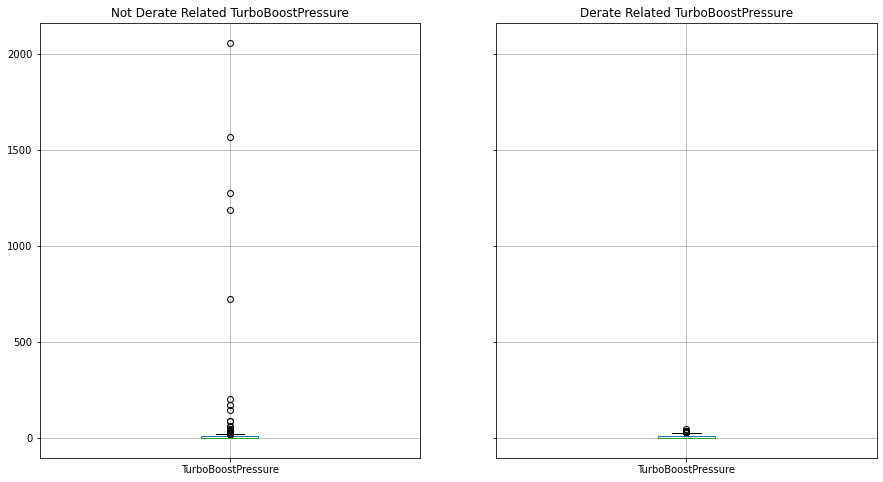

In [16]:
problem_cols_num = [
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IntakeManifoldTemperature',
    'LampStatus',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure']

for x in problem_cols_num:
    fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)
    spn_not_related_to_derate.boxplot(x, ax = axes[0])
    spn_prior_to_any_derate.boxplot(x, ax = axes[1])
    axes[0].set_title('Not Derate Related ' + x)
    axes[1].set_title('Derate Related ' + x)

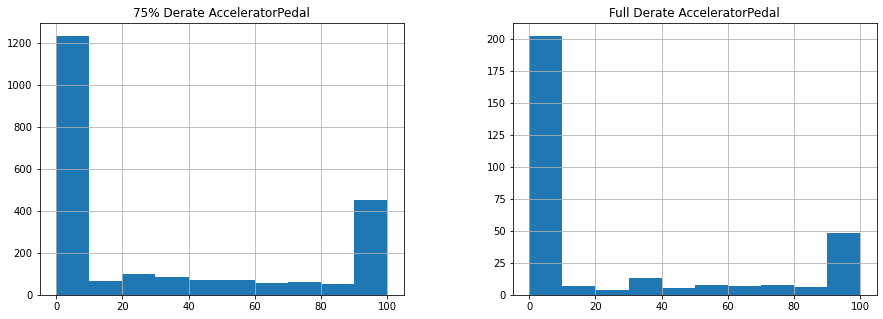

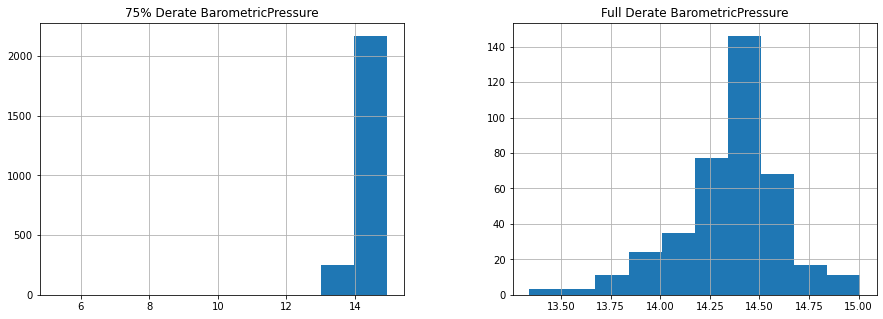

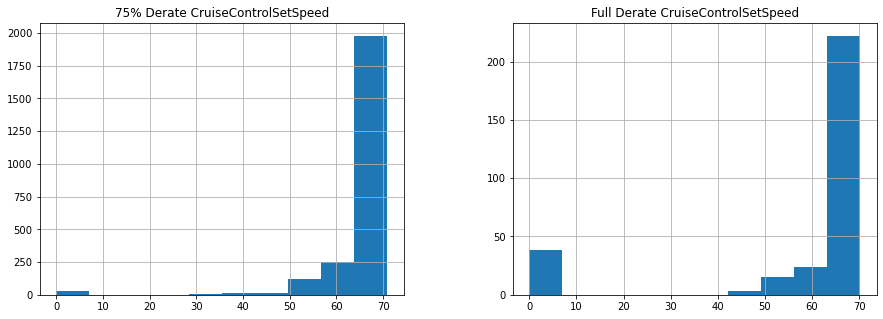

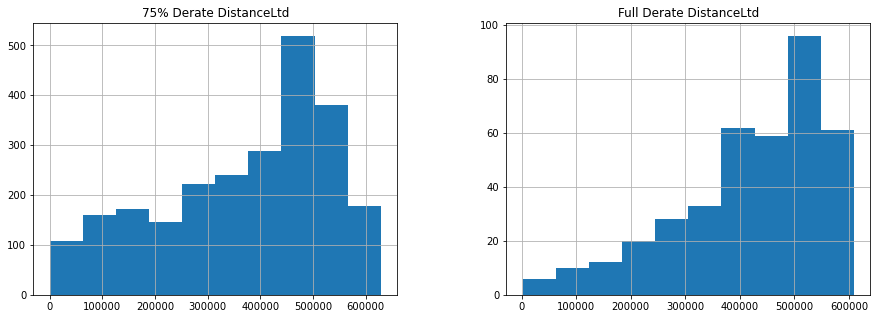

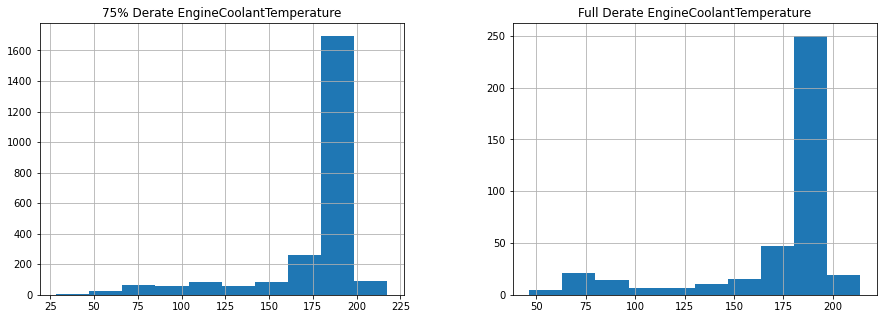

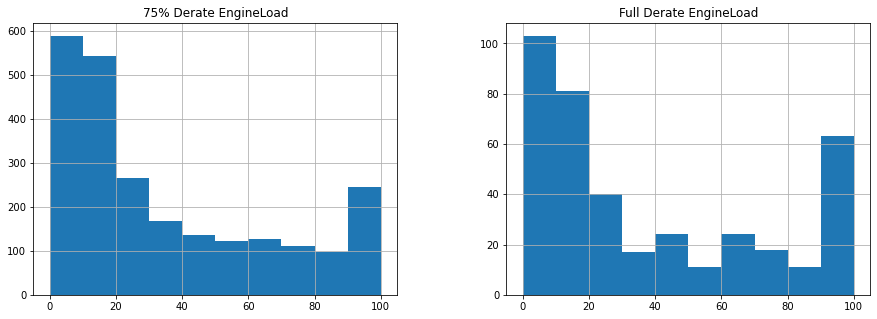

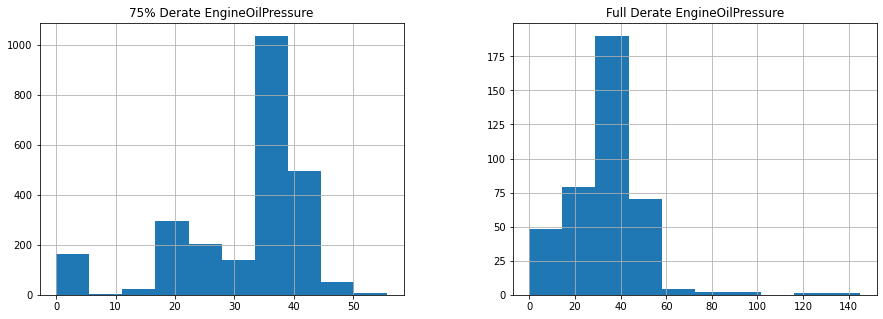

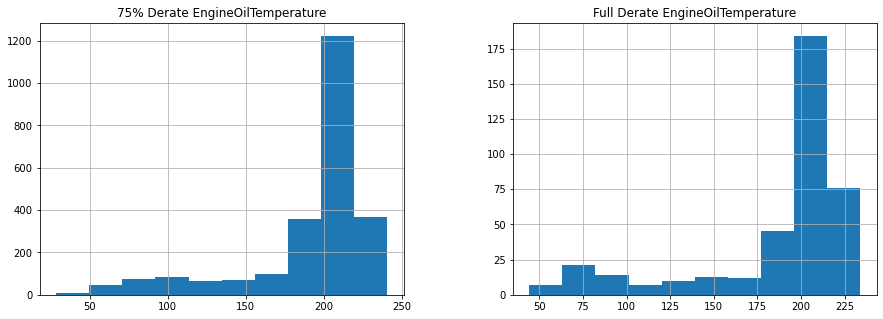

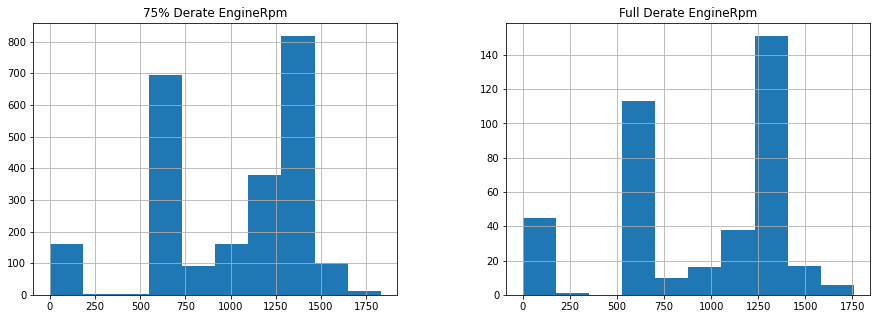

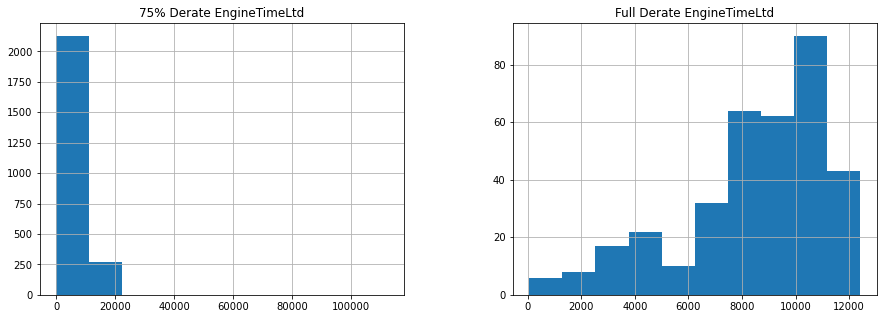

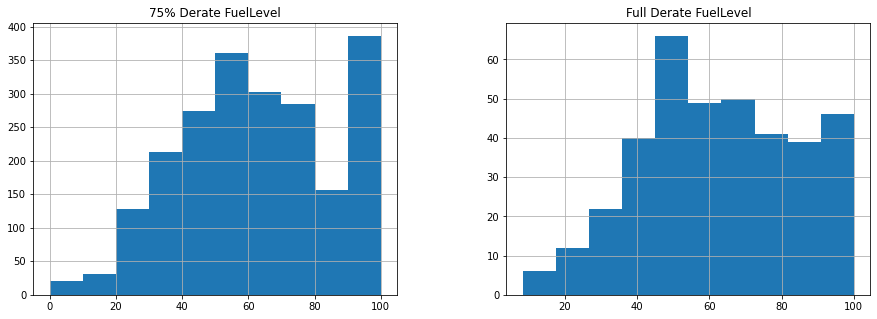

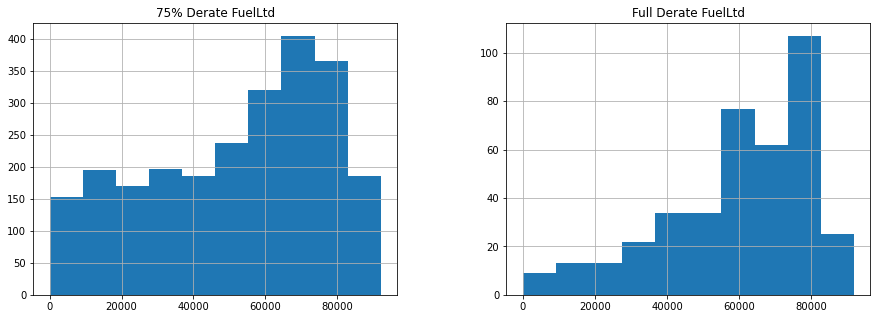

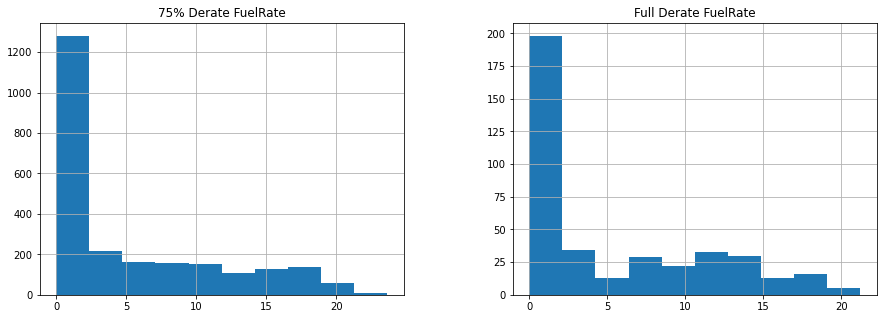

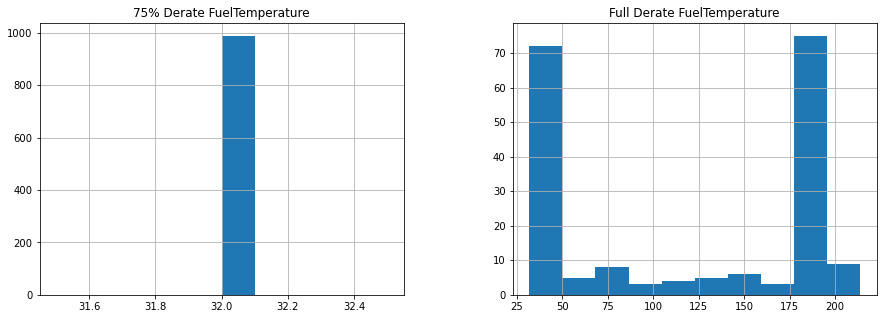

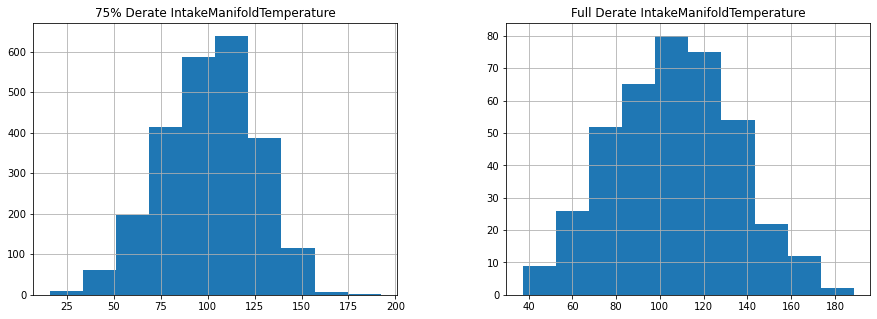

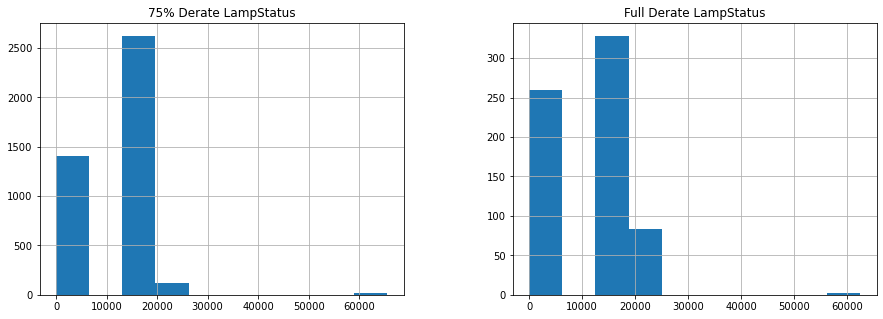

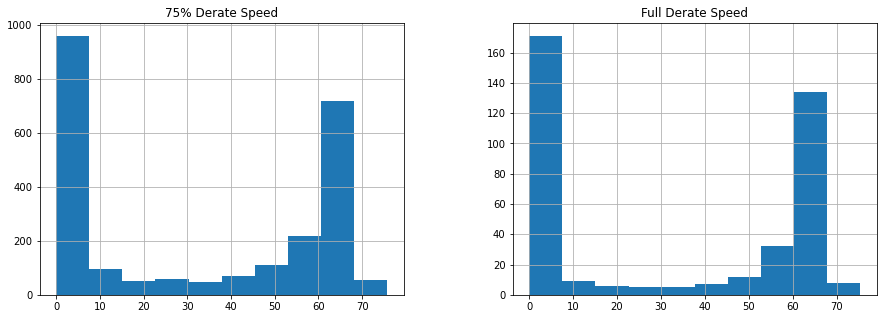

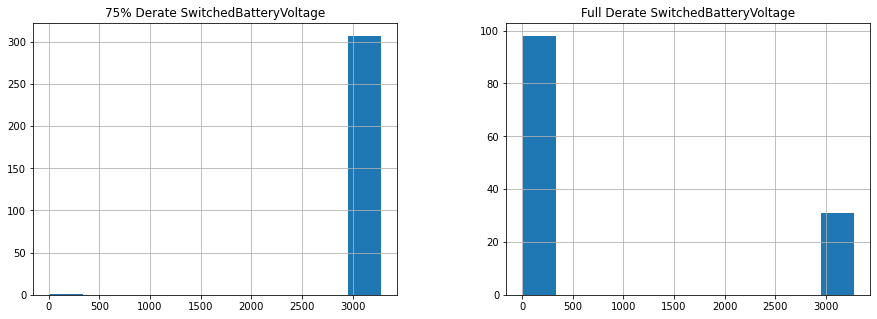

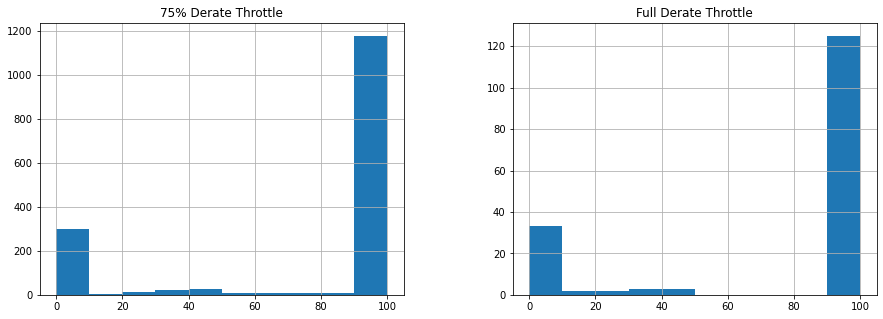

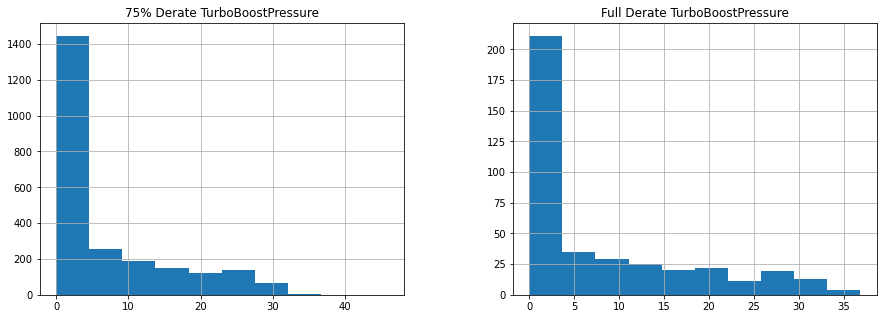

In [17]:
problem_cols_num = [
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IntakeManifoldTemperature',
    'LampStatus',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure']

for x in problem_cols_num:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    spn_prior_to_75_derate.hist(x, ax = axes[0])
    spn_prior_to_full_derate.hist(x, ax = axes[1])
    axes[0].set_title('75% Derate ' + x)
    axes[1].set_title('Full Derate ' + x)

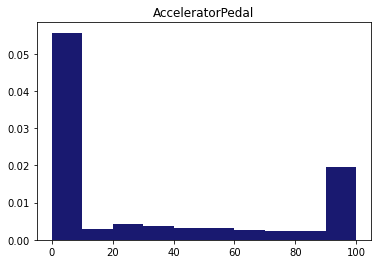

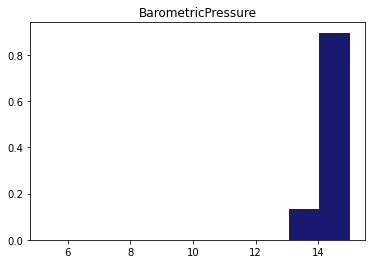

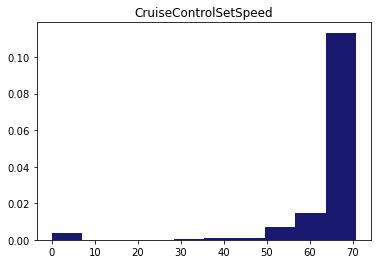

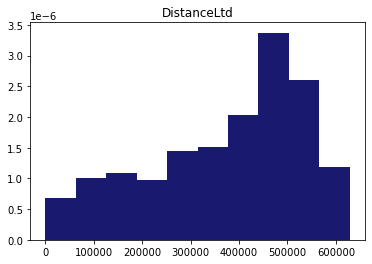

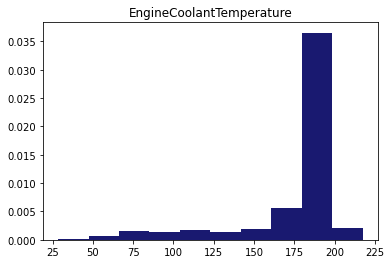

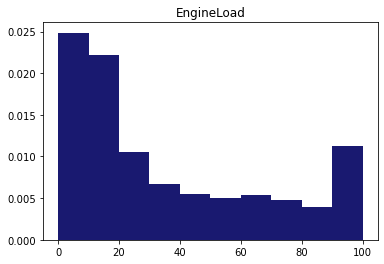

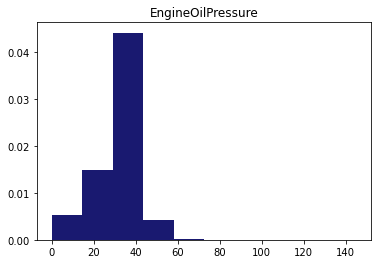

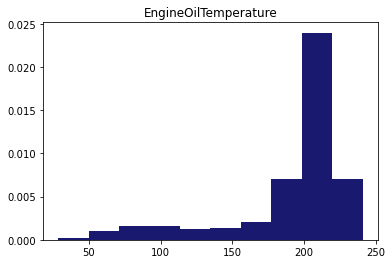

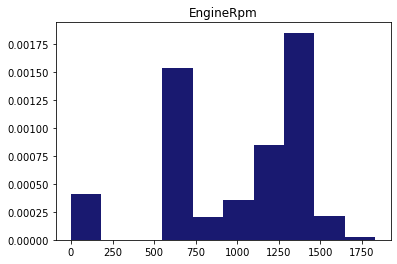

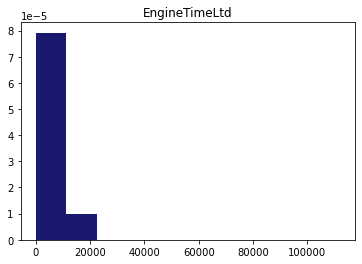

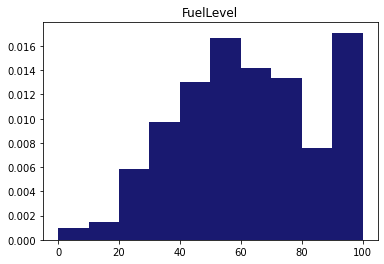

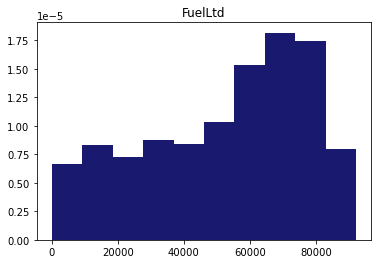

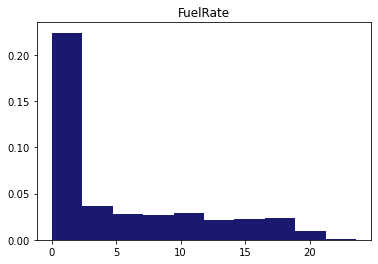

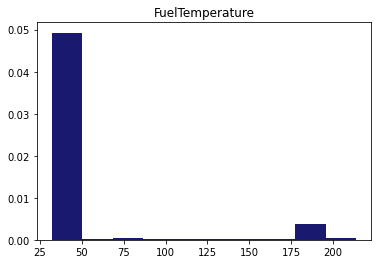

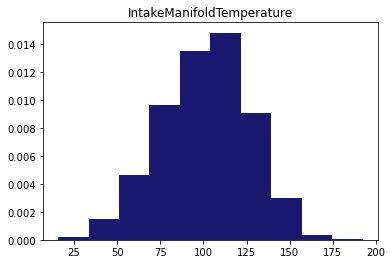

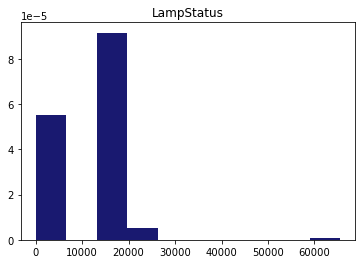

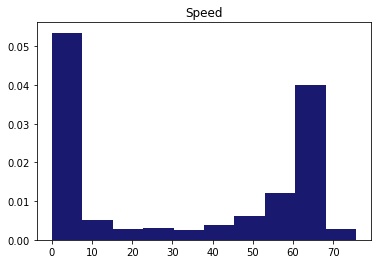

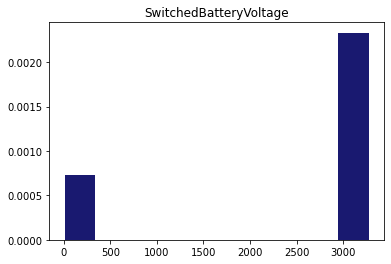

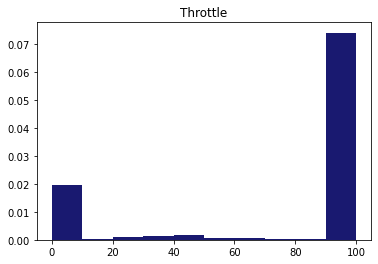

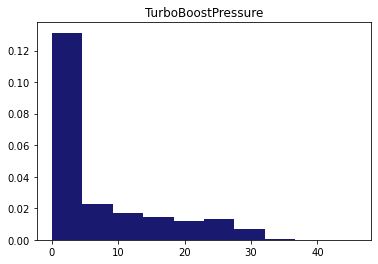

In [33]:
problem_cols_num = [
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IntakeManifoldTemperature',
    'LampStatus',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure']

for x in problem_cols_num:
    plt.hist(spn_prior_to_any_derate[x], color = 'midnightblue', density = True)
    plt.title(x)
    plt.show()

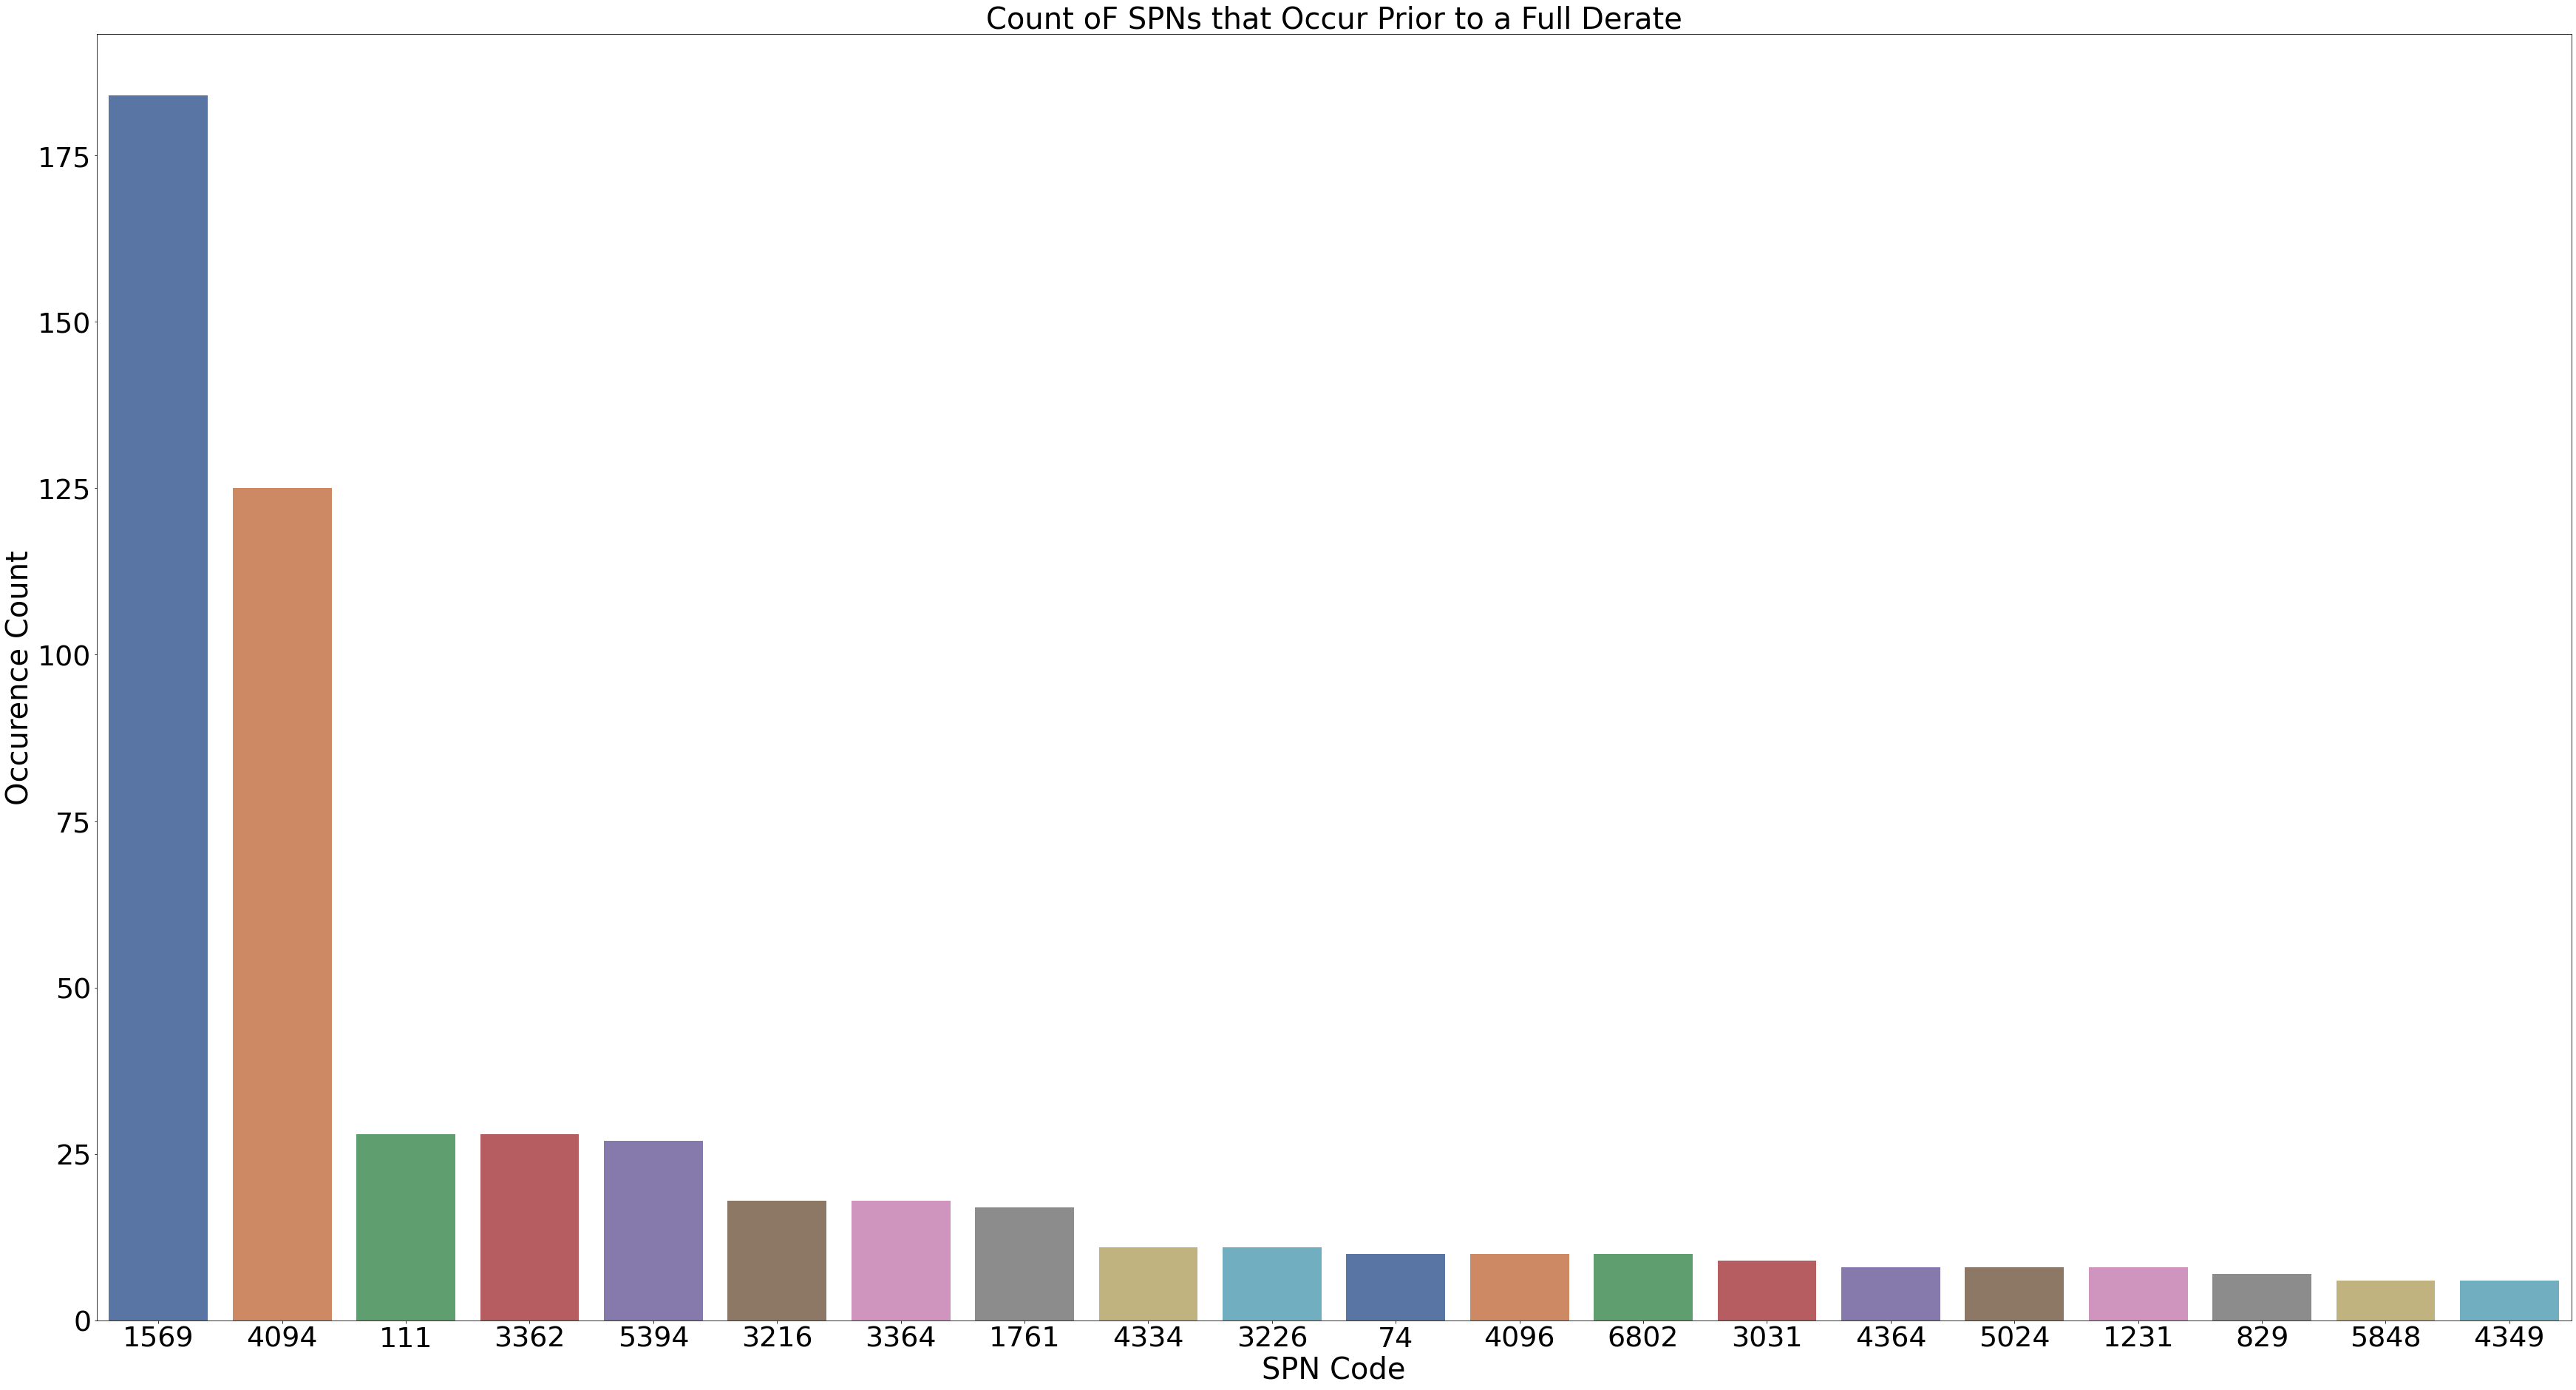

In [19]:
fontsize = 40

fig, ax = plt.subplots(figsize=(60, 32))
sns.barplot(x = 'spn', 
            y = 'EquipmentID', 
            data = spn_count, 
            dodge =False, 
            palette = "deep",
            ax = ax,
            order = spn_count.sort_values('EquipmentID', ascending=False).spn)

plt.xlabel('SPN Code', fontsize = fontsize)
plt.xticks(fontsize = fontsize - 2)

plt.ylabel('Occurence Count', fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)

plt.title('Count oF SPNs that Occur Prior to a Full Derate', fontsize = fontsize);

In [20]:
derate_mask = (((ob_faults['spn'] == 1569) & (ob_faults['fmi'] == 31)) | (ob_faults['spn'] == 5246))

test = ob_faults[derate_mask]
test_list = list(test['EquipmentID'].unique())
test_list

['310',
 '309',
 '308',
 '307',
 '306',
 '305',
 '304',
 '302',
 '301',
 '2211',
 '2209',
 '2143',
 '2120',
 '2111',
 '2109',
 '2089',
 '2082',
 '2027',
 '2021',
 '2020',
 '2019',
 '2018',
 '2017',
 '2015',
 '2013',
 '2012',
 '2011',
 '2010',
 '2009',
 '2008',
 '2007',
 '2006',
 '2005',
 '2004',
 '2002',
 '2000',
 '1999',
 '1997',
 '1996',
 '1995',
 '1994',
 '1993',
 '1992',
 '1991',
 '1989',
 '1988',
 '1986',
 '1985',
 '1984',
 '1982',
 '1981',
 '1980',
 '1979',
 '1978',
 '1977',
 '1976',
 '1975',
 '1972',
 '1971',
 '1970',
 '1969',
 '1968',
 '1967',
 '1966',
 '1965',
 '1964',
 '1963',
 '1962',
 '1961',
 '1959',
 '1958',
 '1957',
 '1956',
 '1954',
 '1953',
 '1952',
 '1951',
 '1950',
 '1949',
 '1948',
 '1947',
 '1946',
 '1945',
 '1944',
 '1942',
 '1940',
 '1939',
 '1938',
 '1937',
 '1935',
 '1934',
 '1933',
 '1932',
 '1931',
 '1930',
 '1928',
 '1927',
 '1926',
 '1925',
 '1924',
 '1922',
 '1921',
 '1920',
 '1919',
 '1918',
 '1917',
 '1916',
 '1914',
 '1913',
 '1912',
 '1911',
 '1909',
 

<AxesSubplot:>

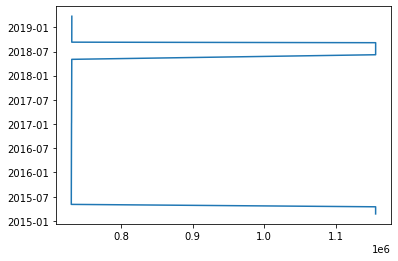

In [21]:
test2 = ob_faults[ob_faults['EquipmentID'] == '1721']
test2['EventTimeStamp'].plot()

In [22]:
ob_faults[ob_faults['spn'] == 1068]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate,full_derate
20790,693912,14066642,2017-01-23 09:39:55,Incorrect Data Brake Signal Sensor 2,NaN,AAAI000031*AAAM000036*BB41259 *A82J140612A_9...,5N37150797,EC80ESP,BNDWS,11,1068,2,True,127,NaN,309,105378377,35.153101,-86.591990,2017-01-19 14:38:55,693912,0.0,14.2100,False,64.62260,176789.4,174.2,0.0,0.00,NaN,0.000,5090.20,100.0,25951.337786,0.000000,NaN,True,141.8,1279.0,True,NaN,NaN,NaN,NaN,0.00,0,0
20784,691062,13998391,2017-01-19 09:46:35,Incorrect Data Brake Signal Sensor 2,NaN,BB41103* BB41104*,S221411247,EC60-adv,BNDWS,11,1068,2,True,127,NaN,309,105442799,36.731250,-87.478888,2017-01-19 09:47:11,691062,39.2,14.3550,False,64.62260,176487.9,177.8,25.0,41.18,190.0625,1245.250,5077.10,60.8,25905.636021,3.288952,NaN,True,116.6,1279.0,False,NaN,6.291383,NaN,100.0,2.61,0,0
20783,691060,13998369,2017-01-19 09:46:18,Incorrect Data Brake Signal Sensor 2,NaN,NaN,NaN,NaN,NaN,11,1068,2,False,127,NaN,309,105442799,36.730972,-87.477037,2017-01-19 09:46:14,691060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65535.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
19996,636365,12803723,2016-11-16 05:06:07,Incorrect Data Brake Signal Sensor 2,NaN,BB41103* BB41104*,S221411247,EC60-adv,BNDWS,11,1068,2,True,127,NaN,309,105442799,35.940879,-86.437083,2016-11-16 05:06:43,636365,0.0,14.3550,True,64.62260,168703.3,185.0,78.0,41.18,186.1250,1331.250,4736.05,74.4,24703.124841,12.125540,NaN,True,80.6,1279.0,False,NaN,64.816780,NaN,45.6,16.24,0,0
18473,352897,6965533,2016-01-20 11:36:38,Incorrect Data Brake Signal Sensor 2,NaN,unknown,unknown,unknown,unknown,11,1068,2,True,127,NaN,309,105442799,36.180740,-86.438287,2016-01-20 11:37:14,352897,87.2,14.4275,False,64.62260,134111.7,183.2,71.0,38.86,218.9750,1337.625,3261.90,52.0,19457.064146,10.580120,32.0,True,78.8,1279.0,False,NaN,65.010960,NaN,56.0,13.92,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42301,360474,7084436,2016-01-26 18:31:36,Incorrect Data Brake Signal Sensor 2,NaN,unknown,unknown,unknown,unknown,11,1068,2,False,127,NaN,1374,105420909,36.877407,-85.661759,2016-01-26 18:31:31,360474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
42298,360471,7084397,2016-01-26 18:29:00,Incorrect Data Brake Signal Sensor 2,NaN,unknown,unknown,unknown,unknown,11,1068,2,True,127,NaN,1374,105420909,36.877731,-85.661388,2016-01-26 18:29:35,360471,2.8,14.2825,False,66.48672,584638.6,161.6,7.0,20.30,187.9250,645.375,11841.00,54.4,88781.490290,0.647223,NaN,True,62.6,1279.0,NaN,NaN,3.961241,NaN,NaN,0.58,0,0
42297,360397,7082591,2016-01-26 16:53:55,Incorrect Data Brake Signal Sensor 2,NaN,unknown,unknown,unknown,unknown,11,1068,2,False,127,NaN,1374,105420909,36.346574,-86.256018,2016-01-26 16:53:50,360397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
42294,360392,7082508,2016-01-26 16:49:44,Incorrect Data Brake Signal Sensor 2,NaN,unknown,unknown,unknown,unknown,11,1068,2,True,127,NaN,1374,105420909,36.299074,-86.263472,2016-01-26 16:50:19,360392,0.0,14.5000,False,66.48672,584564.9,170.6,32.0,16.24,196.4750,663.625,11839.50,57.2,88770.791322,1.096317,NaN,True,66.2,1279.0,NaN,NaN,3.077729,NaN,NaN,0.87,0,0


In [23]:
ob_faults[(ob_faults['spn'] == 5246)]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate,full_derate
1186335,1053753,60949742,2018-09-07 11:22:40,NaN,NaN,05317106*04075152*092613211021*09300006*G1*BDR*,79731935,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,306,105414795,35.997500,-86.595092,2018-09-07 11:23:15,1053753,0.0,14.4275,False,47.22421,304061.8,179.6,19.0,24.36,189.2750,596.625,9392.9,64.4,42194.616834,0.713267,32.0,True,149.0,22527.0,False,NaN,0.0,NaN,0.0,0.29,1,1
14503,1083374,69085173,2018-11-21 13:48:29,NaN,NaN,unknown,unknown,unknown,unknown,49,5246,19,False,42,NaN,305,105362919,38.192546,-85.707685,2018-11-20 23:30:06,1083374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
14500,1082051,68976239,2018-11-20 14:37:43,NaN,NaN,unknown,unknown,unknown,unknown,49,5246,19,True,42,NaN,305,105362919,38.192268,-85.707453,2018-11-20 14:38:19,1082051,0.0,14.5725,False,0.00000,279409.7,156.2,13.0,46.98,161.3750,650.750,10804.7,26.8,44678.890811,1.426534,69.8,True,102.2,255.0,True,NaN,0.0,NaN,0.0,0.87,1,1
14497,1080477,68574413,2018-11-16 13:12:46,NaN,NaN,unknown,unknown,unknown,unknown,49,5246,19,False,40,NaN,305,105362919,38.192453,-85.707685,2018-11-16 13:12:41,1080477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
14494,1080396,68549599,2018-11-16 10:25:51,NaN,NaN,unknown,unknown,unknown,unknown,49,5246,19,True,40,NaN,305,105362919,38.192546,-85.707685,2018-11-16 10:26:27,1080396,0.0,14.5000,False,0.00000,279374.4,167.0,10.0,43.50,171.2750,650.500,10799.8,38.0,44671.361907,0.528346,64.4,True,123.8,255.0,True,NaN,0.0,NaN,0.0,0.29,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,85159,2918021,2015-06-12 07:18:25,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,False,1,NaN,1366,105340123,35.146064,-86.578935,2015-06-12 07:18:21,85159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
36406,85158,2918010,2015-06-12 06:13:27,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,NaN,1366,105340123,35.146018,-86.578888,2015-06-12 07:17:28,85158,0.0,14.3550,False,66.48672,507636.9,186.8,16.0,21.46,192.9875,649.625,10450.0,NaN,77645.053266,0.792519,NaN,True,134.6,22527.0,True,NaN,0.0,3276.75,NaN,0.58,1,1
24754,85811,2928718,2015-06-12 15:35:22,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,NaN,1339,105366200,37.035324,-86.336018,2015-06-12 15:35:58,85811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1122188,5810,1071907,2015-02-25 14:47:00,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,False,1,NaN,1329,105400037,39.399629,-82.974814,2015-02-25 14:46:56,5810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [24]:
test2 = ob_faults.groupby(['EquipmentID', 'spn', pd.Grouper(key='EventTimeStamp', freq='D')]).count().reset_index()
test2

,EquipmentID,spn,EventTimeStamp,RecordID,ESS_Id,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,fmi,active,activeTransitionCount,faultValue,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate,full_derate
0,1327,596,2015-05-07,2,2,2,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,2,1,0,1,1,0,1,2,2
1,1327,3216,2015-05-19,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,0,1,1,1
2,1327,3216,2015-05-26,3,3,3,0,3,3,3,3,3,3,3,3,0,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,2,1,3,1,0,1,1,0,1,3,3
3,1327,50353,2015-05-04,2,2,0,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,2,1,0,1,1,0,1,2,2
4,1328,111,2015-02-23,2,2,2,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216175,310,5848,2017-01-02,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
216176,310,5848,2017-06-08,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
216177,R1762,1761,2015-02-24,4,4,4,0,4,4,4,4,4,4,4,4,0,4,4,4,4,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,2,0,2,2,2,2,4,4
216178,R1762,5848,2015-02-26,2,2,0,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,0,1,1,1,1,2,2


In [25]:
test2[(test2['spn'].shift(-1) == 5246) | (test2['spn'].shift(-1) == 5246) | (test2['spn'].shift(-1) == 5246) | (test2['spn'].shift(-1) == 5246)]

,EquipmentID,spn,EventTimeStamp,RecordID,ESS_Id,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,fmi,active,activeTransitionCount,faultValue,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate,full_derate
47,1329,4344,2015-02-25,2,2,0,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,2,2
429,1339,4364,2015-06-07,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1
4692,1366,4794,2015-10-21,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4693,1366,5246,2015-06-12,2,2,0,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,2,1,0,1,1,0,1,2,2
4694,1366,5246,2015-06-13,2,2,0,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,2,1,0,1,1,0,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214395,305,5246,2018-11-12,2,2,0,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,0,1,0,1,1,2,2
214396,305,5246,2018-11-15,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
214397,305,5246,2018-11-16,3,3,0,0,3,3,3,3,3,3,3,3,0,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,0,1,0,1,1,3,3
214398,305,5246,2018-11-20,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1


In [26]:
test = ob_faults[(ob_faults['eventDescription'].astype('str').str.contains(r'Incorrect Data\D+')) | (ob_faults['spn'] == 5246)][['eventDescription', 'EquipmentID', 'EventTimeStamp', 'spn', 'fmi']]

In [27]:
pd.set_option('display.max_rows', 10)
test.sort_values(['EquipmentID', 'EventTimeStamp'])

,eventDescription,EquipmentID,EventTimeStamp,spn,fmi
1122185,NaN,1329,2015-02-25 13:53:08,5246,0
1122188,NaN,1329,2015-02-25 14:47:00,5246,0
1122194,Incorrect Data Front Operator Wiper Switch,1329,2015-04-14 01:31:28,2863,2
1122195,Incorrect Data Front Operator Wiper Switch,1329,2015-04-14 01:44:45,2863,2
23939,Incorrect Data Front Operator Wiper Switch,1329,2015-07-10 02:08:59,2863,2
...,...,...,...,...,...
23859,Incorrect Data Wheel Sensor ABS Axle 1 Left,310,2019-11-12 00:16:41,789,2
23860,Incorrect Data J1939 Network #1 Primary Vehicl...,310,2019-11-12 00:24:39,639,2
23861,Incorrect Data Wheel Sensor ABS Axle 1 Left,310,2019-11-12 00:25:16,789,2
1187333,Incorrect Data J1939 Network #1 Primary Vehicl...,R1764,2015-02-25 06:08:43,639,2
